# Guía No. 4 - Simulaciones de Monte Carlo
----
by: Diego Dorado

## Modelo de Ising 2D
----

Considere el modelo de Ising en la red cuadrada de $N = L \times L$ sitios (parámetro de red unitario) con interacciones entre primeros vecinos:

$$
H
=
-J\sum_{\langle i,j \rangle}S_iS_j
-
B\sum_iS_i
$$

Usando condiciones de contorno periódicas y tomando la energía en unidades de $k_B$ (esto es, tomando $k_B=1$) implemente un programa para simular las propiedades termodinámicas del modelo usando el algoritmo de Metropolis.

### Algoritmo de Metropolis

El algoritmo de Metropolis permite simular sistemas en equilibrio termodinámico mediante una cadena de configuraciones que respeta la distribución de Boltzmann.  
En el caso del modelo de Ising en 2D, una configuración corresponde al estado de todos los espines en la red.

1. **Inicialización de la configuración**: Elegir una configuración inicial arbitraria $ \alpha $.

    *Ising:* $ \alpha = (S_1, S_2, \dots, s_N)$, con $s_i = \pm 1$, representa todos los espines iniciales de la red.  

2. **Selección de un espín candidato**: Elegir una nueva configuración $\alpha'$ por algún método y se calcula $\Delta E = E(\alpha') - E(\alpha)$

    *Ising:* Elegir un sitio $ i $ de la red y proponer un cambio (flip) de espín: $ S_i \to -S_i $
     
   - El sitio puede elegirse:
       - **Secuencialmente:** recorrer todos los sitios en orden.
       - **Aleatoriamente:** seleccionar con probabilidad uniforme $ 1/N $.

3. **Criterio de aceptación**
   - Si $ \Delta E \leq 0 $, aceptar siempre el cambio.  
   - Si $ \Delta E > 0 $, aceptar el cambio con probabilidad: $p = e^{-\beta \Delta E}$ y se rechaza con probabilidad $1-p=1- e^{-\beta \Delta E}$.

    Para implementar esto en el código:  
     - Generar un número aleatorio $ r \in [0,1) $.  
     - Aceptar el cambio si $ r < p $.  

4. **Actualización de la configuración**
   - Si el cambio se acepta, la nueva configuración $ \alpha' $ pasa a ser el estado actual.  
   - Si se rechaza, se mantiene la configuración $ \alpha $.

5. **Repetición del proceso**
   - Repetir los pasos 2–5 muchas veces para generar una cadena de configuraciones.
   - Cada barrido de $ N $ intentos de flip se considera un **Monte Carlo step (MCS)**.

## Código
-----

### Paquetes
---

In [ ]:
using Statistics
using Interpolations
using BenchmarkTools, StaticArrays
using Random
using Plots
using LaTeXStrings
using Base.Threads
using DelimitedFiles

### Funciones

Algoritmo Metrópolis [optimizado](https://shinaoka.github.io/hpc_julia/docs/2dIsing.html) para Ising 2D

In [2]:
######################################################
# Algoritmo de Metropolis para el modelo de Ising 2D #
######################################################

# Energía de la red
function energy(s; J=1.0, B=0.0)
    Lx, Ly = size(s)
    E = 0.0
    for i in 1:Lx
        for j in 1:Ly
            S = s[i,j]
            # vecinos periódicos
            E -= J * S * (s[ifelse(i==Lx,1,i+1), j] + s[i, ifelse(j==Ly,1,j+1)])
            E -= B * S
        end
    end
    return E
end

function ising2d_ifelse!(s, β, niters, rng=default_rng())
    m, n = size(s)
    min_h = -4
    max_h = 4
    prob = [1/(1+exp(-2*β*h)) for h in min_h:max_h]
    for iter in 1:niters
        for j in 1:n 
            for i in 1:m
                NN = s[ifelse(i == 1, m, i-1), j]
                SS = s[ifelse(i == m, 1, i+1), j]
                WW = s[i, ifelse(j == 1, n, j-1)]
                EE = s[i, ifelse(j == n, 1, j+1)]
                h = NN + SS + WW + EE
                s[i,j] = ifelse(rand(rng) < prob[h-min_h+1], +1, -1)
            end
        end
    end
end

function ising_magnetization_vs_T(T_list; L=32, N_therm=5_000, N_samples=10_000)
    s = rand(Int8[-1, 1], L, L)
    
    # Arrays para guardar todas las cantidades
    m_values   = zeros(length(T_list))
    m2_values  = zeros(length(T_list))
    m4_values  = zeros(length(T_list))
    H_values   = zeros(length(T_list))
    H2_values  = zeros(length(T_list))

    for (k, T) in enumerate(T_list)
        β = 1 / T
        rng = Random.default_rng()

        # Termalización
        ising2d_ifelse!(s, β, N_therm, rng)

        # Muestreo
        m_accum = 0.0
        m2_accum = 0.0
        m4_accum = 0.0
        H_accum = 0.0
        H2_accum = 0.0

        for _ in 1:N_samples
            ising2d_ifelse!(s, β, 10, rng)  # unos cuantos sweeps por muestra
            m = mean(s)
            E = energy(s)  # calculamos energía para H y H^2

            m_accum  += abs(m)
            m2_accum += m^2
            m4_accum += m^4
            H_accum  += E
            H2_accum += E^2
        end

        # Promediar
        m_values[k]  = m_accum / N_samples
        m2_values[k] = m2_accum / N_samples
        m4_values[k] = m4_accum / N_samples
        H_values[k]  = H_accum / N_samples
        H2_values[k] = H2_accum / N_samples
    end

    return m_values, m2_values, m4_values, H_values, H2_values
end

ising_magnetization_vs_T (generic function with 1 method)

In [3]:
##########################
# Cálculo de observables #
##########################

function suceptibility(m2_values, m_values, T_list, L)
    χ_values = (L^2 ./ T_list) .* (m2_values .- m_values.^2)
    return χ_values
end

function suceptibility_exact(T_list)
    m_exact = zeros(length(T_list))
    Tc = 2 / log(1 + sqrt(2))
    for (i,T) in enumerate(T_list)
        if T < Tc
            m_exact[i] = (1 - sinh(2/T)^(-4))^(1/8)
        else
            m_exact[i] = 0.0
        end
    end
    return m_exact
end

function heat_capacity(h2_values, h_values, T_list, L)
    C_values = (1 ./ (L^2 .* T_list.^2)) .* (h2_values .- h_values.^2)
    return C_values
    
end

function heat_capacity_exact(T_list)
    Tc = 2 / log(1 + sqrt(2))
    C_exact = -log.(abs.(T_list .- Tc))
    return C_exact
end

heat_capacity_exact (generic function with 1 method)

### Main
---

#### **Cálculo numérico**

In [41]:
# Configuración inicial
J = 1.0            # Constante de acoplamiento
B = 0.0            # Campo magnético externo
# Intervalos con diferente densidad de puntos
T1 = range(1, 2, length=20)
T2 = range(2, 3, length=100)
T3 = range(3, 5, length=40)

# Concatenar los tres rangos (evitando repetir los puntos frontera)
T_list = vcat(T1[1:end-1], T2[1:end-1], T3);

# Lista de tamaños

# L = [16, 32, 64, 128, 200]
L = [16, 32, 64, 200]

# Lista de colores para graficar
colors = [:blue, :red, :green, :orange, :purple];

In [ ]:
for l in L
    m_vals, m2_vals, m4_vals, H_vals, H2_vals = ising_magnetization_vs_T(T_list; L=l, N_therm=10*(l^2), N_samples=2_000)

    
    # Guardar todo en CSV
    filename = "observables_L$(l).csv"
    writedlm(filename, hcat(T_list, m_vals, m2_vals, m4_vals, H_vals, H2_vals), ',')
end

#### **a.**

A campo nulo calcule las curvas de magnetización $\langle |m| \rangle_L$, susceptibilidad y calor específico en función de $T/J$, para tamaños $L = 16, 32, 64, 128$ y $200$. Para cada magnitud grafique simultáneamente las curvas correspondientes a los diferentes tamaños. En el caso de la magnetización y el calor específico grafique también la solución exacta para la red infinita. Calcule en las mismas simulaciones las cantidades $\langle m^2 \rangle_L$ y $\langle m^4 \rangle_L$. Recuerde que cerca de la temperatura crítica los tiempos de relajación al equilibrio aumentan. Realice algunos test preliminares.

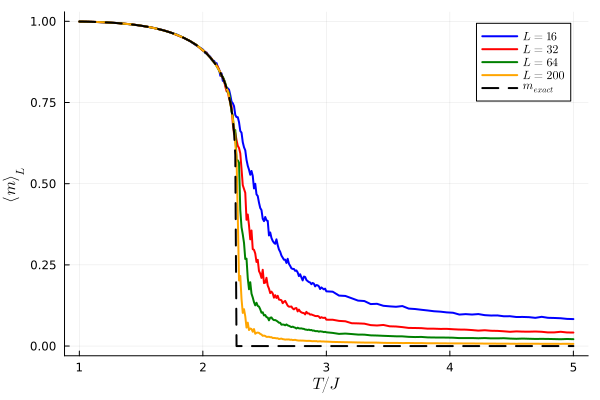

"c:\\Users\\diego\\Documents\\DIEGO\\COMPUTADORAS\\Coding\\Julia\\monte-carlo\\m_plot.pdf"

In [43]:
# Inicializar el plot
p = plot(xlabel=L"$T/J$", ylabel=L"$\langle m \rangle_L$", legend=:topright, lw=3)

for (i, L) in enumerate(L)
    # Cargar datos
    filename = "observables_L$(L).csv"
    data = readdlm(filename, ',', Float64)

    T_list = data[:,1]        # Primera columna: temperatura
    m_vals = data[:,2]        # Segunda columna: <m>

    # Graficar magnetización
    plot!(p, T_list, m_vals, label=L"$L=%$L$", color=colors[i], lw=2)
end

# Graficar la solución exacta
plot!(p, T_list, suceptibility_exact(T_list), label=L"$m_{exact}$", color=:black, style=:dash, lw=2)

display(p)
savefig(p, "m_plot.pdf")

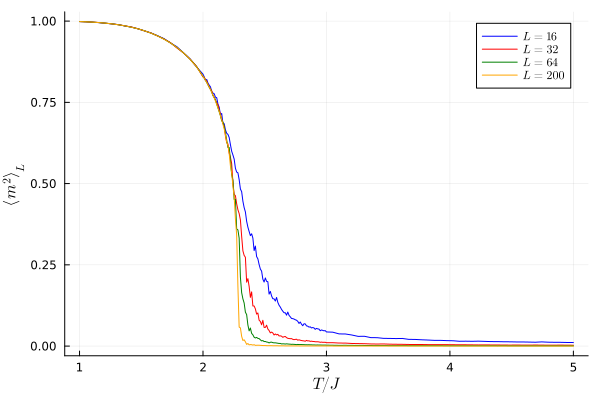

"c:\\Users\\diego\\Documents\\DIEGO\\COMPUTADORAS\\Coding\\Julia\\monte-carlo\\m2_plot.pdf"

In [44]:
# Inicializar el plot
p = plot(xlabel=L"$T/J$", ylabel=L"$\langle m^2 \rangle_L$", legend=:topright, lw=3)

for (i, L) in enumerate(L)
    # Cargar datos
    filename = "observables_L$(L).csv"
    data = readdlm(filename, ',', Float64)

    T_list = data[:,1]        # Primera columna: temperatura
    m_vals = data[:,3]        # Segunda columna: <m^2>
    # Graficar
    plot!(p, T_list, m_vals, label=L"$L=%$L$", color=colors[i])
end

display(p)
savefig(p, "m2_plot.pdf")

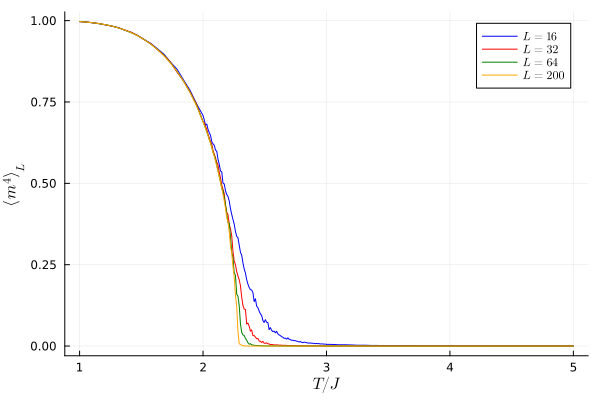

"c:\\Users\\diego\\Documents\\DIEGO\\COMPUTADORAS\\Coding\\Julia\\monte-carlo\\m4_plot.pdf"

In [45]:
# Inicializar el plot
p = plot(xlabel=L"$T/J$", ylabel=L"$\langle m^4 \rangle_L$", legend=:topright, lw=3)

for (i, L) in enumerate(L)
    # Cargar datos
    filename = "observables_L$(L).csv"
    data = readdlm(filename, ',', Float64)

    T_list = data[:,1]        # Primera columna: temperatura
    m_vals = data[:,4]        # cuarta columna: <m^4>

    # Graficar
    plot!(p, T_list, m_vals, label=L"$L=%$L$", color=colors[i])
end

display(p)
savefig(p, "m4_plot.pdf")

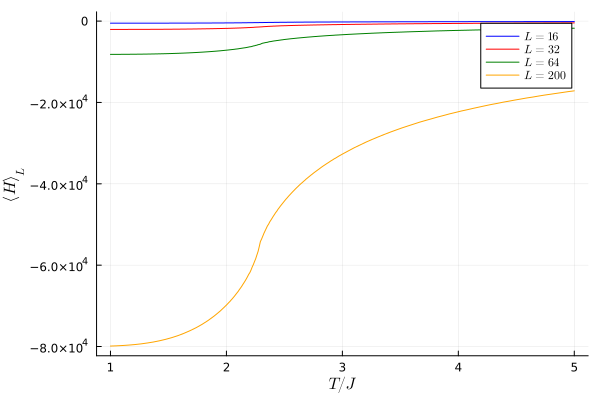

"c:\\Users\\diego\\Documents\\DIEGO\\COMPUTADORAS\\Coding\\Julia\\monte-carlo\\h_plot.pdf"

In [46]:
# Inicializar el plot
p = plot(xlabel=L"$T/J$", ylabel=L"$\langle H \rangle_L$", legend=:topright, lw=3)

for (i, L) in enumerate(L)
    # Cargar datos
    filename = "observables_L$(L).csv"
    data = readdlm(filename, ',', Float64)

    T_list = data[:,1]        # Primera columna: temperatura
    m_vals = data[:,5]        # Segunda columna: <H>

    # Graficar
    plot!(p, T_list, m_vals, label=L"$L=%$L$", color=colors[i])
end

display(p)
savefig(p, "h_plot.pdf")

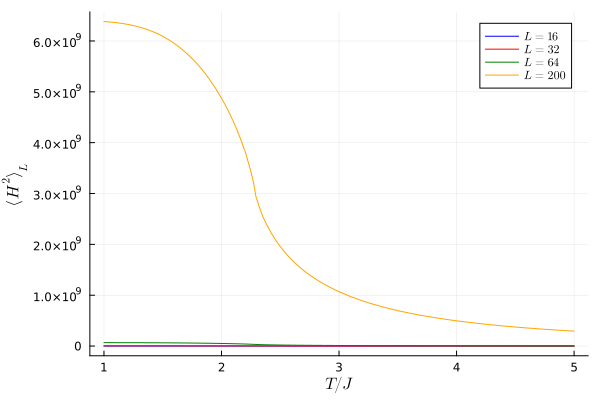

"c:\\Users\\diego\\Documents\\DIEGO\\COMPUTADORAS\\Coding\\Julia\\monte-carlo\\h2_plot.pdf"

In [47]:
# Inicializar el plot
p = plot(xlabel=L"$T/J$", ylabel=L"$\langle H^2 \rangle_L$", legend=:topright, lw=3)

for (i, L) in enumerate(L)
    # Cargar datos
    filename = "observables_L$(L).csv"
    data = readdlm(filename, ',', Float64)

    T_list = data[:,1]        # Primera columna: temperatura
    m_vals = data[:,6]        # Sexta columna: <H^2>

    # Graficar
    plot!(p, T_list, m_vals, label=L"$L=%$L$", color=colors[i])
end

display(p)
savefig(p, "h2_plot.pdf")

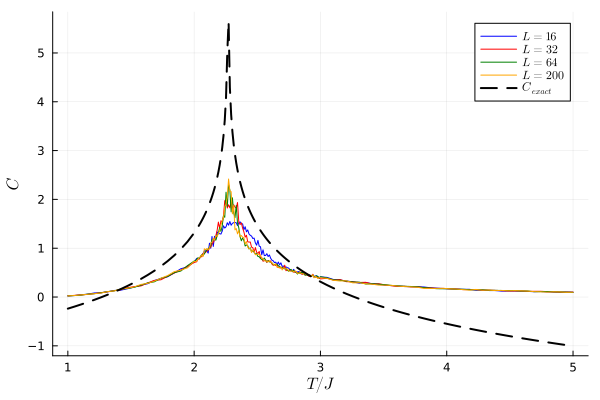

"c:\\Users\\diego\\Documents\\DIEGO\\COMPUTADORAS\\Coding\\Julia\\monte-carlo\\heat_capacity_plot.pdf"

In [48]:
# Lista de colores para graficar
colors = [:blue, :red, :green, :orange, :purple]

# Inicializar el plot
p = plot(xlabel=L"$T/J$", ylabel=L"$C$", legend=:topright, lw=4)

for (i, L) in enumerate(L)
    # Cargar datos
    filename = "observables_L$(L).csv"
    data = readdlm(filename, ',', Float64)

    T_list = data[:,1]        
    h_vals = data[:,5]       
    h2_vals = data[:,6]

    s = heat_capacity(h2_vals, h_vals, T_list, L)

    # Graficar
    plot!(p, T_list, s, label=L"$L=%$(L)$", color=colors[i])
end

# Graficar la solución exacta
plot!(p, T_list, heat_capacity_exact(T_list), label=L"$C_{exact}$", color=:black, style=:dash, lw=2)

display(p)
savefig(p, "heat_capacity_plot.pdf")

#### **b.** 
Observe que las curvas de magnetización, en lugar de anularse en la temperatura crítica, presentan un punto de inflexión para saturar a altas temperaturas en un valor constante que decae como $1/\sqrt{N}$ (verifíquelo!). A medida que aumenta el tamaño el punto de inflexión converge a la temperatura crítica. Extrapolando entonces a $1/L \to 0$ el punto de inflexión estimado para cada tamaño $L$ estime la temperatura crítica de la red infinita y compare con el resultado exacto.


In [49]:
filename = "observables_L128.csv"
data = readdlm(filename, ',', Float64)

T_list = data[:,1]        # Primera columna: temperatura
m_vals = data[:,2];        # Segunda columna: <m>

dM_dT = diff(m_vals) ./ diff(T_list)
T_mid = @view T_list[2:end-1]
T_inf = T_mid[argmax(abs.(dM_dT))]

2.2626262626262625

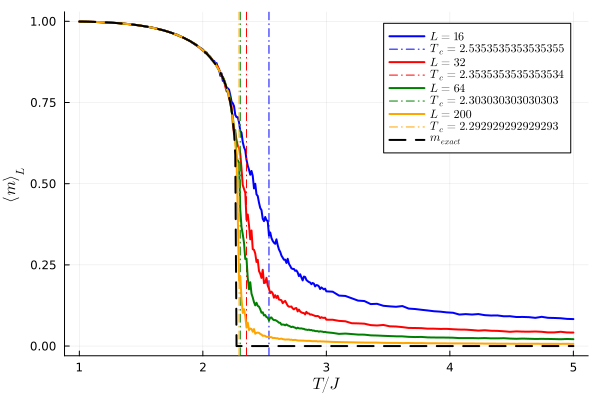

"c:\\Users\\diego\\Documents\\DIEGO\\COMPUTADORAS\\Coding\\Julia\\monte-carlo\\inflex-point.pdf"

In [50]:
# Inicializar el plot
p = plot(xlabel=L"$T/J$", ylabel=L"$\langle m \rangle_L$", legend=:topright, lw=3)
T_inf = Float64[]

for (i, l) in enumerate(L)
    # Cargar datos
    filename = "observables_L$(l).csv"
    data = readdlm(filename, ',', Float64)

    T_list = data[:,1]        # Primera columna: temperatura
    m_vals = data[:,2]        # Segunda columna: <m>  

    # Graficar magnetización
    plot!(p, T_list, m_vals, label=L"$L=%$l$", color=colors[i], lw=2)

    #graficar T criticos aproximados
    dM_dT = diff(m_vals) ./ diff(T_list)
    T_mid = @view T_list[2:end-1]
    push!(T_inf, T_mid[argmax(abs.(dM_dT))])
    vline!([T_inf[end]], linestyle=:dashdot, color=colors[i], label=L"$T_c =%$(T_inf[end]) $")
end

# Graficar la solución exacta
plot!(p, T_list, suceptibility_exact(T_list), label=L"$m_{exact}$", color=:black, style=:dash, lw=2)

display(p)
savefig(p, "inflex-point.pdf")

Aproximamos la temperatura como:

$$
T_{infl} (L) = T_c + a\frac{1}{L}
$$

y utilizando el método de mínimos cuadrados, tomanto $a$ y $T_c$ como parámetros interpolación, calculamos la temperatura crítica para $\frac{1}{L} \rightarrow 0$

In [51]:
# Vector de 1/L
x = 1.0 ./ L

# Matriz de diseño para el modelo T_infl = Tc + a * (1/L)
A = [ones(length(x)) x]

# Ajuste lineal por mínimos cuadrados
coeffs = A \ T_inf # \ operador de resolución de sistemas lineales en Julia

Tc_est = coeffs[1]
a_est  = coeffs[2]

println("Tc estimado = $Tc_est")
println("a = $a_est")

Tc estimado = 2.2458419247229133
a = 4.384531461917669


#### **c.**
Usando las relaciones de escala de tamaño finito

$$
\langle m^2 \rangle_L = L^{-2\beta/\nu}F_2(Lt^\nu)
$$
$$
\langle m^4 \rangle_L = L^{-4\beta/\nu}F_4(Lt^\nu)
$$

Estime la temperatura crítica a través del **cumulante de Binder** ([Binder, 1981](https://link.springer.com/article/10.1007/BF01293604))

$$
U_L = \frac{\langle m^4 \rangle_L}{\langle m^4 \rangle_L^2}
$$

y compare con la estimación anterior.

---

**Escalamiento finito y funciones de escalamiento en sistemas críticos**

Cerca del punto crítico, los sistemas que exhiben una transición de fase continua presentan una **divergencia en la longitud de correlación** $\xi$, que caracteriza el tamaño típico de las regiones correlacionadas. En el límite termodinámico ($L \to \infty$), esta longitud diverge según una ley de potencias:
$$
\xi \sim |t|^{-\nu},
$$
donde $t = (T - T_c)/T_c$ es la temperatura reducida, y $\nu$ es el **exponente crítico de la longitud de correlación**.  

Sin embargo, en un sistema de tamaño finito $L$, la divergencia de $\xi$ se ve truncada: el sistema no puede sostener correlaciones mayores que su propio tamaño, por lo que efectivamente se cumple
$$
\xi \lesssim L.
$$
Esto introduce una dependencia explícita con $L$ en los observables físicos cercanos a la transición, dando origen a la **teoría del escalamiento finito (finite-size scaling, FSS)** ([Fisher, 1072](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.28.1516)).

Por esto, se postula que para cualquier observable crítico $Q(T,L)$ depende de $T$ y $L$ sólo a través del **cociente adimencional** $L/\xi$, o equivalentemente $L^{1/\nu}t$:

$$
Q(T,L) = L^{-\kappa}F_Q(L^{1/\nu t})
$$

donde $F_Q$ es una función de escala universal y $\kappa$ es un exponente asociado al observable.

**Magnetización y sus momentos**

La magnetización $m$ y sus momentos (como $\langle m^2 \rangle$ o $\langle m^4 \rangle$) son cantidades que dependen del tamaño del sistema y de la distancia al punto crítico.  
Según la hipótesis de escalamiento, el valor medio de la magnetización obedece la relación

$$
\langle m^2 \rangle_L \sim L^{-2\beta/\nu} \, F_2(L^{1/\nu} t),
$$

y análogamente para el cuarto momento:

$$
\langle m^4 \rangle_L \sim L^{-4\beta/\nu} \, F_4(L^{1/\nu} t).
$$

Aquí:
* $\beta$ es el **exponente crítico de la magnetización**, que describe cómo se anula ésta al aproximarse a $T_c$: $m \sim |t|^\beta$.
* $\nu$ es el **exponente de la longitud de correlación**, introducido antes.
* $F_2$ y $F_4$ son **funciones de escalamiento universales**, que dependen del producto adimensional $L^{1/\nu} t$.

**Cumulante de Binder adimensional**
Consideremos el cumulante de Binder:
$$
U_L
=
\frac{\langle m^4 \rangle_L}{\langle m^2 \rangle_L^2}
$$
sustituyendo las expresiones a escala
$$
U_L
=
\frac{L^{-4\beta/\nu}F_4(L^{1/\nu}t)}{[L^{-2\beta/\nu}F_2(L^{1/\nu}t)]^2}
=
\frac{F_4(L^{1/\nu}t)}{[F_2(L^{1/\nu}t)]^2}
$$
cancelandose los factores de $L$. Por lo tanto
$$
U_L = f_U(L^{1/\nu}t)
$$
lo que implica que $U_L$ *no depende directamente del tamaño*, sino únicamante de la variable de escala $L^{1/\nu}$.

Luego, en el punto crítico, $t=0$

$$
U_L = f_U(0)
$$

la cuál es una función **independiente** de $L$.

Por lo tanto, si graficamos $U_L(T)$ para distintos tamaños $L$, todas las curvas deben **cruzarse por el mismo punto** $T=T_c$

In [52]:
function moving_average_vec(x::Vector{Float64}, k::Int)
    n = length(x)
    y = zeros(Float64, n)
    for i in 1:n
        jmin = max(1, i-k)
        jmax = min(n, i+k)
        y[i] = mean(x[jmin:jmax])
    end
    return y
end

moving_average_vec (generic function with 1 method)

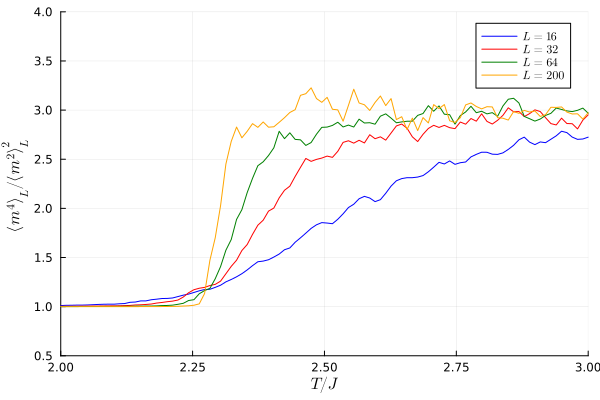

In [53]:
# Inicializar el plot
p = plot(
    xlabel=L"$T/J$",
    ylabel=L"$\langle m^4 \rangle_L / \langle m^2 \rangle_L^2$",
    ylims=(0.5, 4),
    xlims = (2,3), 
    legend=:topright, 
    lw=3
    )

for (i, l) in enumerate(L)
    # Cargar datos
    filename = "observables_L$(l).csv"
    data = readdlm(filename, ',', Float64)

    T_list = data[:,1]        # Primera columna: temperatura
    m_vals2 = data[:,3]        # Segunda columna: <m^2>
    m_vals4 = data[:,4]        # Segunda columna: <m^2>

    u = m_vals4 ./ (m_vals2).^2

    # suavizar las curvas
    k = 1
    U_smooth = moving_average_vec(u, k)

    # Graficar
    plot!(p, T_list, U_smooth, label=L"$L=%$l$", color=colors[i])
end

display(p)

In [38]:
interpU = Dict()
for (i, l) in enumerate(L)
    # Cargar datos
    filename = "observables_L$(l).csv"
    data = readdlm(filename, ',', Float64)

    T_list = data[:,1]        # Primera columna: temperatura
    m_vals2 = data[:,3]        # Segunda columna: <m^2>
    m_vals4 = data[:,4]        # Segunda columna: <m^2>

    u = m_vals4 ./ (m_vals2).^2

    # suavizar las curvas
    k = 1
    U_smooth = moving_average_vec(u, k)

    # Interpolar
    itp = interpolate([T_list U_smooth], (BSpline(Cubic(Natural(OnGrid())))))
    interpU[l] = itp
end

In [54]:
# Guardaremos las curvas interpoladas
curvas_interp = []

# Rango fino de T para evaluación
T_fino = 2.25:0.001:2.5  # más fino que tus datos discretos

for (i, l) in enumerate(L)
    # Cargar datos
    filename = "observables_L$(l).csv"
    data = readdlm(filename, ',', Float64)

    T_list = data[:,1]        # Temperatura
    m_vals2 = data[:,3]       # <m^2>
    m_vals4 = data[:,4]       # <m^4>

    # Cálculo de cumulante de Binder
    u = m_vals4 ./ (m_vals2).^2

    # Suavizado opcional (promedio móvil)
    k = 1
    U_smooth = moving_average_vec(u, k)

    # Interpolación spline lineal
    itp = interpolate((T_list,), U_smooth, Gridded(Linear()))
    push!(curvas_interp, itp)
end

# Evaluar todas las curvas en el rango fino de T
curvas_eval = [c.(T_fino) for c in curvas_interp]

# Calcular la varianza en cada T
σ2 = [var([curvas_eval[i][j] for i in 1:length(curvas_eval)]) for j in 1:length(T_fino)]

# Encontrar T donde la varianza es mínima
idx_min = argmin(σ2)
T_interseccion = T_fino[idx_min]

println("El punto de intersección aproximado es T = $T_interseccion")


El punto de intersección aproximado es T = 2.274


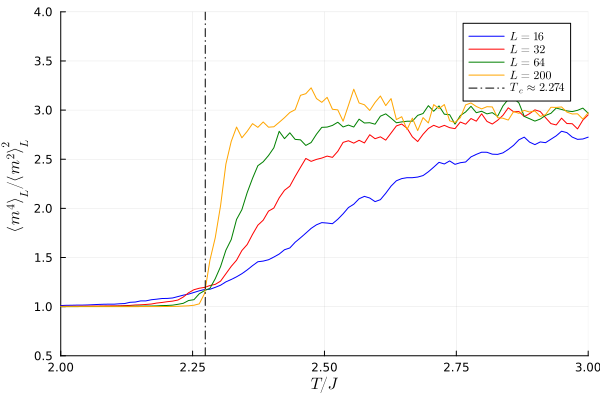

"c:\\Users\\diego\\Documents\\DIEGO\\COMPUTADORAS\\Coding\\Julia\\monte-carlo\\binder-cumulant.pdf"

In [55]:
# Inicializar el plot
p = plot(
    xlabel=L"$T/J$",
    ylabel=L"$\langle m^4 \rangle_L / \langle m^2 \rangle_L^2$",
    ylims=(0.5, 4),
    xlims = (2,3), 
    legend=:topright, 
    lw=3
    )

for (i, l) in enumerate(L)
    # Cargar datos
    filename = "observables_L$(l).csv"
    data = readdlm(filename, ',', Float64)

    T_list = data[:,1]        # Primera columna: temperatura
    m_vals2 = data[:,3]        # Segunda columna: <m^2>
    m_vals4 = data[:,4]        # Segunda columna: <m^2>

    u = m_vals4 ./ (m_vals2).^2

    # suavizar las curvas
    k = 1
    U_smooth = moving_average_vec(u, k)

    # Graficar
    plot!(p, T_list, U_smooth, label=L"$L=%$l$", color=colors[i])
end

vline!([T_interseccion], linestyle=:dashdot, color=:black, label=L"$T_c \approx %$(round(T_interseccion, digits=4)) $")

display(p)
savefig(p, "binder-cumulant.pdf")

#### **d.**

Es posible ver que el máximo de la susceptibilidad ocurre en una temperatura pseudo-cr´ıtica $T^*(L) = T_c + AL^{-1/\nu}$, donde $A$ es una constante. Además, el valor del máximo crece con el tamaño como $L^{\gamma / \nu}$. Usando estos resultados estime $\gamma / \nu$. También estime la temperatura crítica y compare el resultado con los valores obtenidos anteriormente.

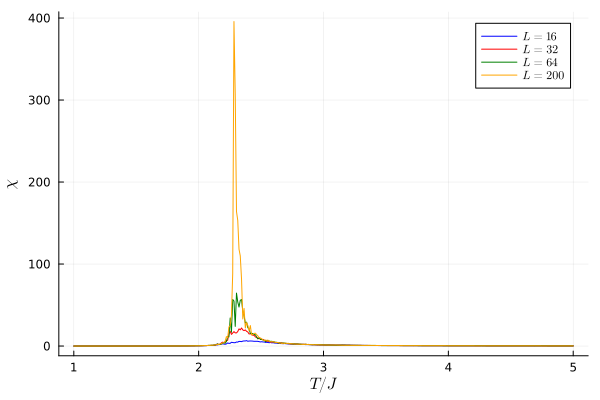

"c:\\Users\\diego\\Documents\\DIEGO\\COMPUTADORAS\\Coding\\Julia\\monte-carlo\\suceptibility_plot.pdf"

In [26]:
# Inicializar el plot
p = plot(
    xlabel=L"$T/J$", 
    ylabel=L"$\chi$", 
    legend=:topright, 
    lw=4)

for (i, L) in enumerate(L)
    # Cargar datos
    filename = "observables_L$(L).csv"
    data = readdlm(filename, ',', Float64)

    T_list = data[:,1]        
    m_vals = data[:,2]       
    m2_vals = data[:,3]

    s = suceptibility(m2_vals, m_vals, T_list, L)

    # Graficar
    plot!(p, T_list, s, label=L"$L=%$L$", color=colors[i])
end

display(p)
savefig(p, "suceptibility_plot.pdf")